In [1]:
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
from scipy.ndimage.measurements import label
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2

car_data = glob.glob("vehicles/vehicles/**/*.png")
non_car_data = glob.glob("non-vehicles/non-vehicles/**/*.png")
print("number of vehicles",len(car_data))
print("number of non_vehicles",len(non_car_data))

number of vehicles 8792
number of non_vehicles 8968


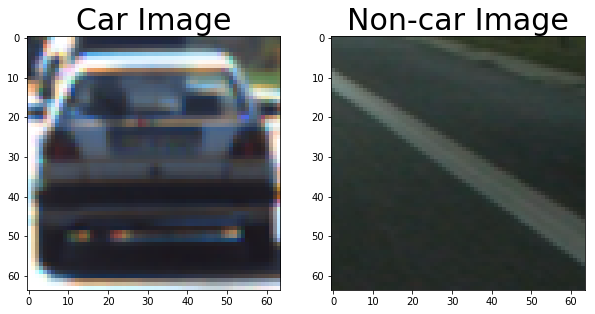

In [2]:
##Analysing on some random image
%matplotlib inline

car_img = mpimg.imread(car_data[4567])
noncar_img = mpimg.imread(non_car_data[2385])
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,10))
ax1.imshow(car_img)
ax1.set_title('Car Image', fontsize=30)
ax2.imshow(noncar_img)
ax2.set_title('Non-car Image', fontsize=30)

In [3]:
import matplotlib.image as mpimg
import numpy as np
import cv2
from skimage.feature import hog
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [4]:
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True, vis = False):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
            feature_image = feature_image.astype(np.float32)/255
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
            feature_image = feature_image.astype(np.float32)/255
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
            feature_image = feature_image.astype(np.float32)/255
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
            feature_image = feature_image.astype(np.float32)/255
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
            feature_image = feature_image.astype(np.float32)/255
    else: feature_image = np.copy(img)   
        
        
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        spatial_features =np.reshape(spatial_features,(1,-1))
        #print(spatial_features.shape)
        #4) Append features to list
        #img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        hist_features =np.reshape(hist_features,(1,-1))
        #print(hist_features.shape)
        #6) Append features to list
        #img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            if vis == True:
                hog_features,hog_img = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=True, feature_vec=True)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        hog_features =np.reshape(hog_features,(1,-1))
        #print(hog_features.shape)
        #print(np.concatenate((spatial_features, hist_features, hog_features)).shape)
        #8) Append features to list
        
        img_features = (np.concatenate((spatial_features, hist_features, hog_features),1))
        #img_features.append(features)
        
        #print(img_features.reshape(1,-1))
        #print(img_features.shape)
    if  vis==True:
        return img_features, hog_img
    else:
        return img_features

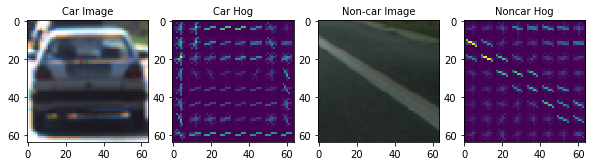

In [5]:
car_features, car_hog = single_img_features(car_img, vis=True)
noncar_feature, noncar_hog = single_img_features(noncar_img, vis=True)
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(10,10))
ax1.imshow(car_img)
ax1.set_title('Car Image', fontsize=10)
ax2.imshow(car_hog)
ax2.set_title('Car Hog', fontsize=10)
ax3.imshow(noncar_img)
ax3.set_title('Non-car Image', fontsize=10)
ax4.imshow(noncar_hog)
ax4.set_title("Noncar Hog", fontsize=10)

In [6]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import train_test_split

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()


def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True, vis = False):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
                feature_image = feature_image.astype(np.float32)/255
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
                feature_image = feature_image.astype(np.float32)/255
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
                feature_image = feature_image.astype(np.float32)/255
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
                feature_image = feature_image.astype(np.float32)/255
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
                feature_image = feature_image.astype(np.float32)/255
        else: feature_image = np.copy(image)      
        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            spatial_features =np.reshape(spatial_features,(1,-1))
            #print(spatial_features.shape)
        #4) Append features to list
        #img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
        if hist_feat == True:
            hist_features = color_hist(feature_image, nbins=hist_bins)
            hist_features =np.reshape(hist_features,(1,-1))
            #print(hist_features.shape)

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_feat == True:
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
            else:
                if vis == True:
                    hog_features,hog_img = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=True, feature_vec=True)
                else:
                    hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        hog_features =np.reshape(hog_features,(1,-1))
        #print(hog_features.shape)
        #print(np.concatenate((spatial_features, hist_features, hog_features)).shape)
        #8) Append features to list
        
        img_features = (np.concatenate((spatial_features, hist_features, hog_features),1)).T
    # Return list of feature vectors
        features.append(img_features)
    
    features = np.squeeze(np.array(features), axis=(2,))
    
    return features


### TODO: Tweak these parameters and see how the results change.
colorspace = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 0 # Can be 0, 1, 2, or "ALL"

t=time.time()
car_features = extract_features(car_data, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel='ALL',
                        spatial_feat=True, hist_feat=True, hog_feat=True, vis = False)
notcar_features = extract_features(non_car_data, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel='ALL',
                        spatial_feat=True, hist_feat=True, hog_feat=True, vis = False)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64) 
print(car_features.shape)
print(notcar_features.shape)
print(X.shape)

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

270.25 Seconds to extract HOG features...
(8792, 8460)
(8968, 8460)
(17760, 8460)
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460


In [7]:
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

79.35 Seconds to train SVC...
Test Accuracy of SVC =  0.9803


In [8]:
def search_windows(img, windows, clf, scaler, cspace='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
                img = feature_image.astype(np.float32)/255
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
                img = feature_image.astype(np.float32)/255
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
                img = feature_image.astype(np.float32)/255
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
                img = feature_image.astype(np.float32)/255
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
                img = feature_image.astype(np.float32)/255
        else: 
            feature_image = np.copy(image)  
            img = feature_image
        
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        
        features = single_img_features(test_img, color_space=cspace, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = X_scaler.transform((features))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [9]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0, 0, 255),6)
    # Return the image
    return img

Sliding Windows


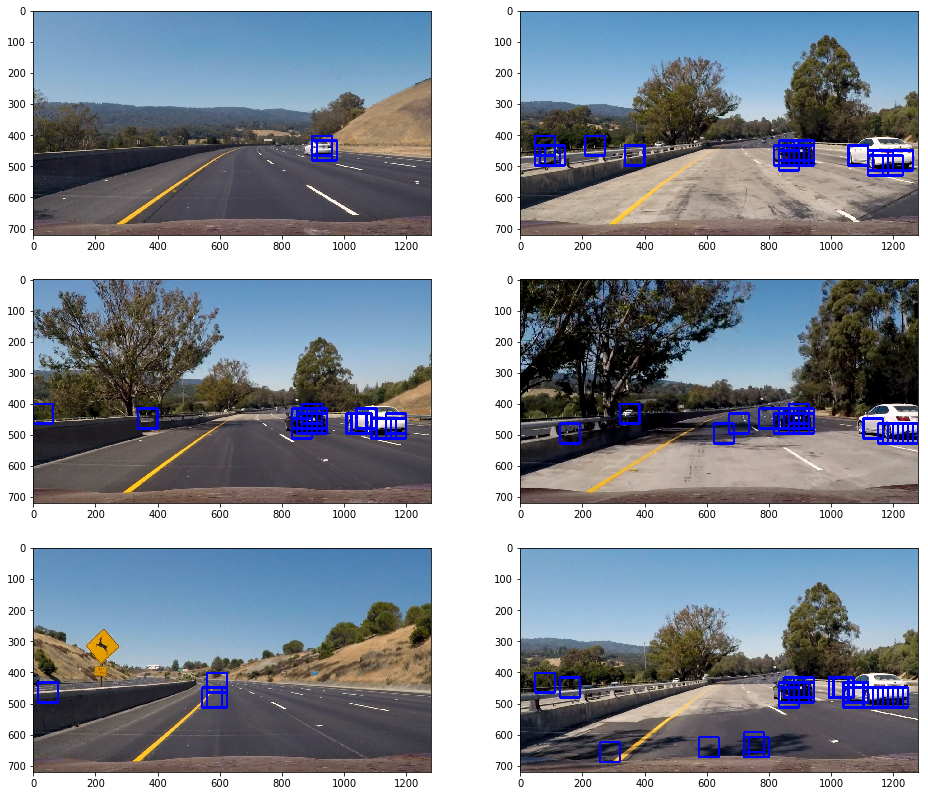

In [12]:
test = glob.glob("test_images/*")
y_start_stop=[400,700]
draw_windows = []

for i in range(len(test)):
    image = mpimg.imread(test[i])
    copy_image = np.copy(image)
    image = image.astype(np.float32)/255
    
    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[400, 700], 
                    xy_window=(64, 64), xy_overlap=(0.75, 0.75))
    
    car_windows = search_windows(image, windows, svc, X_scaler, cspace='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel="ALL", spatial_feat=True, 
                    hist_feat=True, hog_feat=True)
    
    box = draw_boxes(copy_image, car_windows, color=(0, 0, 255), thick=6)
    draw_windows.append(box)
    
# Visualize 
fig, axs = plt.subplots(3, 2, figsize=(16,14))
axs = axs.ravel()

for i, img in enumerate(draw_windows):
    axs[i].imshow(img)
    
print("Sliding Windows")

Sliding Windows


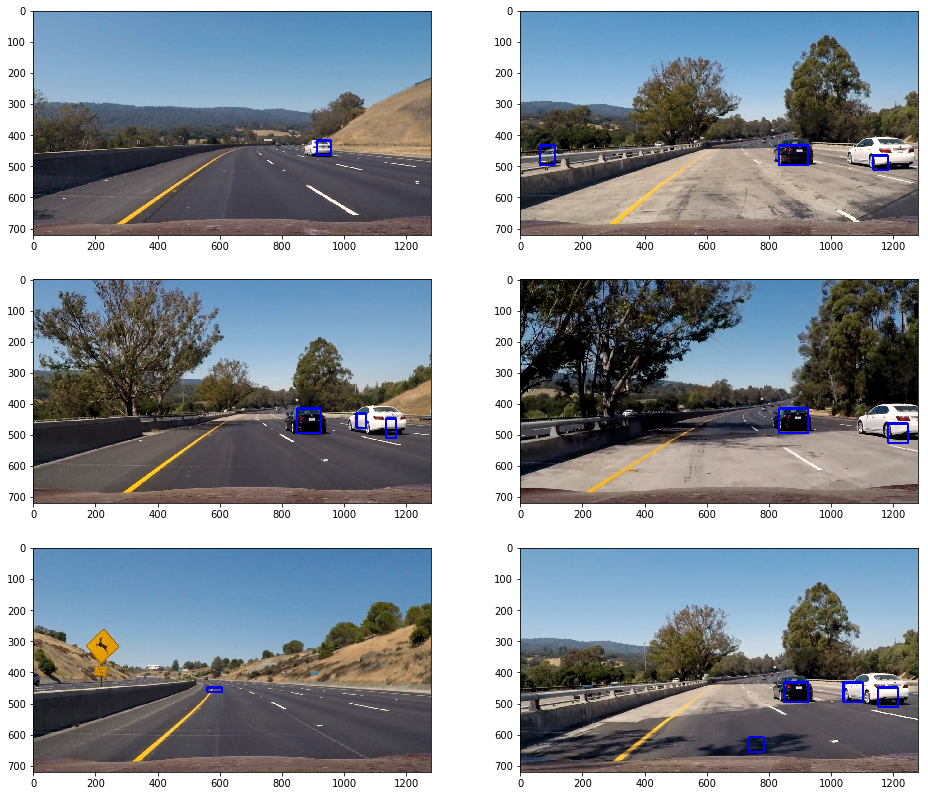

In [15]:
test = glob.glob("test_images/*")
y_start_stop=[400,700]
draw_windows = []

for i in range(len(test)):
    image = mpimg.imread(test[i])
    copy_image = np.copy(image)
    image = image.astype(np.float32)/255
    
    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[400, 700], 
                    xy_window=(64, 64), xy_overlap=(0.75, 0.75))
    
    car_windows = search_windows(image, windows, svc, X_scaler, cspace='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel="ALL", spatial_feat=True, 
                    hist_feat=True, hog_feat=True)
    
    #box = draw_boxes(copy_image, car_windows, color=(0, 0, 255), thick=6)
    #draw_windows.append(box)
    
    heat = np.zeros_like(copy_image[:,:,0]).astype(np.float)

# Add heat to each box in box list
    heat = add_heat(heat,car_windows)
    
# Apply threshold to help remove false positives
    heat = apply_threshold(heat,2)

# Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(copy_image, labels)

    draw_windows.append(draw_img)
#plt.imshow(draw_img)
    
# Visualize 
fig, axs = plt.subplots(3, 2, figsize=(16,14))
axs = axs.ravel()

for i, img in enumerate(draw_windows):
    axs[i].imshow(img)
    
print("Sliding Windows")

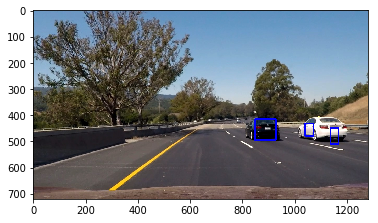

In [29]:
image = mpimg.imread("test_images/test6.jpg")
copy_image = np.copy(image)
image = image.astype(np.float32)/255
    
windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[400, 700], 
                    xy_window=(64, 64), xy_overlap=(0.75, 0.75))
    
car_windows = search_windows(image, windows, svc, X_scaler, cspace='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel="ALL", spatial_feat=True, 
                    hist_feat=True, hog_feat=True)
    
    #box = draw_boxes(copy_image, car_windows, color=(0, 0, 255), thick=6)
    #draw_windows.append(box)
    
heat = np.zeros_like(copy_image[:,:,0]).astype(np.float)

# Add heat to each box in box list
heat = add_heat(heat,car_windows)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,2)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(copy_image, labels)

plt.imshow(draw_img)

In [32]:
def temp(image):
    #image = image
    copy_image = np.copy(image)
    image = image.astype(np.float32)/255
    
    
    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[400, 700], 
                    xy_window=(64, 64), xy_overlap=(0.75, 0.75))
    
    car_windows = search_windows(image, windows, svc, X_scaler, cspace='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel="ALL", spatial_feat=True, 
                    hist_feat=True, hog_feat=True)
    
    #box = draw_boxes(copy_image, car_windows, color=(0, 0, 255), thick=6)
    #draw_windows.append(box)
    
    heat = np.zeros_like(copy_image[:,:,0]).astype(np.float)

# Add heat to each box in box list
    heat = add_heat(heat,car_windows)
    
# Apply threshold to help remove false positives
    heat = apply_threshold(heat,2)

# Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(copy_image, labels)

    plt.imshow(draw_img)

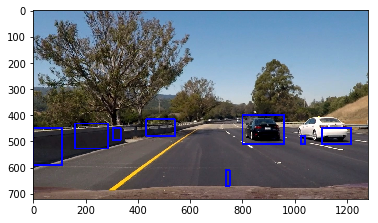

In [36]:
image = mpimg.imread("test_images/test6.jpg")
image = np.array(image)
#image.shape
temp1223(image)

In [12]:
def final_process_img(img):
    copy_image = np.copy(img)
    image = img.astype(np.float32)/255
    
    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[400, 700], 
                    xy_window=(64, 64), xy_overlap=(0.65, 0.65))
    
    car_windows = search_windows(image, windows, svc, X_scaler, cspace='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel="ALL", spatial_feat=True, 
                    hist_feat=True, hog_feat=True)
    heat = np.zeros_like(copy_image[:,:,0]).astype(np.float)
    heat = add_heat(heat,car_windows)
    heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(copy_image, labels)
    return draw_img

In [36]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        return image.astype(np.float32)/255
    if conv == 'BGR2YCrCb':
        image =  cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
        return image.astype(np.float32)/255
    if conv == 'RGB2LUV':
        image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        return image.astype(np.float32)/255
    if conv == 'RGB2HLS':
        image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        return image.astype(np.float32)/255
    else:
        return img

def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    rects = []
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                rects.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return rects

In [37]:
def final_process_img(img):
    copy_image = np.copy(img)
    image = img.astype(np.float32)/255
    
    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[400, 700], 
                    xy_window=(64, 64), xy_overlap=(0.65, 0.65))
    
    car_windows = search_windows(image, windows, svc, X_scaler, cspace='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel="ALL", spatial_feat=True, 
                    hist_feat=True, hog_feat=True)
    heat = np.zeros_like(copy_image[:,:,0]).astype(np.float)
    heat = add_heat(heat,car_windows)
    heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(copy_image, labels)
    return draw_img

In [30]:
def final_process(img):
    copy_image = np.copy(img)
    image = img.astype(np.float32)/255
    
    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[400, 700], 
                    xy_window=(64, 64), xy_overlap=(0.65, 0.65))
    
    car_windows = search_windows(image, windows, svc, X_scaler, cspace='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel="ALL", spatial_feat=True, 
                    hist_feat=True, hog_feat=True)
    
    
    if len(car_windows) > 0:
        detections.add_windows(car_windows)
    
    heatmap_img = np.zeros_like(img[:,:,0])
    for windows in detections.prev_windows:
        heatmap_img = add_heat(heatmap_img, windows)
    heatmap_img = apply_threshold(heatmap_img, 1 + len(detections.prev_windows)//2)
    heatmap = np.clip(heatmap_img, 0, 255)

# Find final boxes from heatmap using label function
    labels = label(heatmap) 
    #labels = label(heatmap_img)
    draw_img = draw_labeled_bboxes(copy_image, labels)
    
    return draw_img
    
    
    
    #box = draw_boxes(copy_image, car_windows, color=(0, 0, 255), thick=6)
    #draw_windows.append(box)
    
    #heat = np.zeros_like(copy_image[:,:,0]).astype(np.float)

# Add heat to each box in box list
    #heat = add_heat(heat,car_windows)
    
# Apply threshold to help remove false positives
    #heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
    #heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
    #labels = label(heatmap)
    #draw_img = draw_labeled_bboxes(copy_image, labels)
    #return draw_img
#    draw_windows.append(draw_img)
#plt.imshow(draw_img)
    
# Visualize 
#fig, axs = plt.subplots(3, 2, figsize=(16,14))
#axs = axs.ravel()

#for i, img in enumerate(draw_windows):
#    axs[i].imshow(img)
    
#print("Sliding Windows")

In [38]:
def final_process_img2(img):
    ystart = 400
    ystop = 700
    scale = 1.5
    spatial_size=(32, 32)
    hist_bins=32
    copy_image = np.copy(img)
    image = img.astype(np.float32)/255
    
    #windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[400, 700], 
     #               xy_window=(64, 64), xy_overlap=(0.65, 0.65))
    
    car_windows = find_cars(image, ystart, ystop, scale, svc, X_scaler, 
                            orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    heat = np.zeros_like(copy_image[:,:,0]).astype(np.float)
    heat = add_heat(heat,car_windows)
    heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(copy_image, labels)
    return draw_img

In [46]:
def final_process2(img):
    copy_image = np.copy(img)
    image = img.astype(np.float32)/255
    ystart = 400
    ystop = 700
    scale = 1.5
    spatial_size=(32, 32)
    hist_bins=32
    copy_image = np.copy(img)
    image = img.astype(np.float32)/255
    #windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[400, 700], 
     #               xy_window=(64, 64), xy_overlap=(0.65, 0.65))
    
    car_windows = find_cars(image, ystart, ystop, scale, svc, X_scaler, 
                            orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    
    
    if len(car_windows) > 0:
        detections.add_windows(car_windows)
    
    heatmap_img = np.zeros_like(img[:,:,0])
    for windows in detections.prev_windows:
        heatmap_img = add_heat(heatmap_img, windows)
    heatmap_img = apply_threshold(heatmap_img, 1 + len(detections.prev_windows)//2)
    heatmap = np.clip(heatmap_img, 0, 255)

# Find final boxes from heatmap using label function
    labels = label(heatmap) 
    #labels = label(heatmap_img)
    draw_img = draw_labeled_bboxes(copy_image, labels)
    
    return draw_img
    

In [31]:
# A class to store detected windows
class Vehicle_Tracker():
    def __init__(self):
        # history of windows from previous n frames
        self.prev_windows = [] 
        
    def add_windows(self, windows):
        self.prev_windows.append(windows)
        if len(self.prev_windows) > 15:
            # remove oldest windows
            self.prev_windows = self.prev_windows[len(self.prev_windows)-15:]

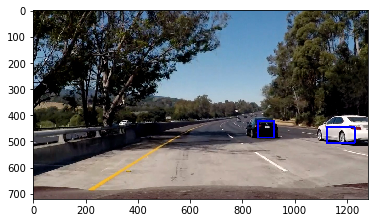

In [13]:
img = mpimg.imread('test_images/test5.jpg')
nn = final_process_img(img)
plt.imshow(nn)

In [14]:
from moviepy.editor import VideoFileClip
#detections = Vehicle_Tracker()
test_out_file = 'test_video_out.mp4'
clip_test = VideoFileClip('test_video.mp4')
clip_test_out = clip_test.fl_image(final_process_img)
%time clip_test_out.write_videofile(test_out_file, audio=False)

[MoviePy] >>>> Building video test_video_out.mp4
[MoviePy] Writing video test_video_out.mp4


 97%|█████████▋| 38/39 [03:25<00:05,  5.40s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out.mp4 

CPU times: user 3min 25s, sys: 112 ms, total: 3min 25s
Wall time: 3min 28s


In [15]:
from moviepy.editor import VideoFileClip
#detections = Vehicle_Tracker()
test_out_file = 'project_video_out.mp4'
clip_test = VideoFileClip('project_video.mp4')
clip_test_out = clip_test.fl_image(final_process_img)
%time clip_test_out.write_videofile(test_out_file, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████▉| 1260/1261 [1:38:16<00:05,  5.50s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

CPU times: user 1h 38min 12s, sys: 3.05 s, total: 1h 38min 15s
Wall time: 1h 38min 18s


In [49]:
from moviepy.editor import VideoFileClip
detections = Vehicle_Tracker()
test_out_file = 'test_video_out.mp4'
clip_test = VideoFileClip('test_video.mp4')
clip_test_out = clip_test.fl_image(final_process)
%time clip_test_out.write_videofile(test_out_file, audio=False)

[MoviePy] >>>> Building video test_video_out.mp4
[MoviePy] Writing video test_video_out.mp4



 97%|█████████▋| 38/39 [02:56<00:04,  4.93s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out.mp4 

CPU times: user 2min 55s, sys: 416 ms, total: 2min 56s
Wall time: 2min 58s


In [50]:
from moviepy.editor import VideoFileClip
detections = Vehicle_Tracker()
test_out_file = 'project_video_out.mp4'
clip_test = VideoFileClip('project_video.mp4')
clip_test_out = clip_test.fl_image(final_process)
%time clip_test_out.write_videofile(test_out_file, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4



100%|█████████▉| 1260/1261 [1:37:32<00:04,  4.63s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

CPU times: user 1h 37min 4s, sys: 27 s, total: 1h 37min 31s
Wall time: 1h 37min 34s
